# Initials

In [50]:
#Import libraries

from imutils import paths
from sklearn.metrics import confusion_matrix,accuracy_score
from scipy.cluster.vq import kmeans,vq
from sklearn.preprocessing import StandardScaler
from PIL import Image
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.pyplot import figure
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import cv2
import random
import pylab as pl
import joblib
import time

# Blazej Dubiel - 10.04.2022

In [51]:
# Check open-cv version (must be 4.4.0!!!)
print(cv2.__version__)

4.5.5


In [52]:
pwd

'/Users/bdubiel97/Desktop/University of Groningen/DL in Forestry/Code'

In [55]:
# Global parameters setup

class config:
    # specify path to the dataset (dataset dir must be  within the same folder as this script)
    # otherwise change
    # DATASET_PATH = 'bark_photos'
    DATASET_PATH = "data/BarkNet"
    
    # set the input height and width
    INPUT_HEIGHT = 966
    INPUT_WIDTH = 414
    
    # subset size
    SUBSET_SIZE = 101
    
    # number of SIFT features to retain
    nfts = 200

In [56]:
# Load all the image paths and randomly shuffle them
print("[INFO] loading image paths...")

imagePaths = []
for image_path1 in os.listdir(config.DATASET_PATH):
    if not image_path1.startswith('.'):
        image_path2 = os.path.join(config.DATASET_PATH, image_path1)
        stop = 0 # initialize the counter
        tempList = os.listdir(image_path2)
        random.shuffle(tempList)
        for image_path3 in tempList:

            stop += 1
            if stop < config.SUBSET_SIZE: 
              image_path3 = os.path.join(image_path2, image_path3)
              imagePaths.append(image_path3)
            else:
              break

np.random.shuffle(imagePaths)
print("Done")

[INFO] loading image paths...
Done


In [57]:
len(imagePaths)

480

In [58]:
# Appending all the samples path and its corresponding labels in a list

# Defining the path for samples
classNames= os.listdir(config.DATASET_PATH)
if '.DS_Store' in classNames:
    classNames.remove('.DS_Store')

len(classNames)

20

# Properties check in order to choose average dimensions of the samples

In [59]:
# Check dimensions of the imgs:
maxH = 0
HighestImage = 0
minH = 10000
LowestImage = 0
maxW = 0
WidestImage =0
minW = 10000
NarrowestImage = 0
avg_H = []
avg_W = []


for image_path1 in os.listdir(config.DATASET_PATH):
    if not image_path1.startswith('.'):
        image_path2 = os.path.join(config.DATASET_PATH, image_path1)
    
    # Create the path for each subdirectory:
        for image_path3 in os.listdir(image_path2):
            image_path3 = os.path.join(image_path2, image_path3)
            img = Image.open(image_path3)
            
            # Checking the average dimensions
            avg_H.append(img.size[1])
            avg_W.append(img.size[0]) 
            
            # Checking the highest images
            if img.size[0] > maxH:
                maxH = img.size[0]
                HighestImage = img.size
                
            # Checking the lowest images
            if img.size[0] < minH:
                minH = img.size[0]
                LowestImage = img.size
                
            # Checking the widest images
            if img.size[1] > maxW:
                maxW = img.size[1]
                WidestImage = img.size
                
            # Checking the narrowest images
            if img.size[1] < minW:
                minW = img.size[1]
                NarrowestImage = img.size

average_height = sum(avg_H)/len(avg_H)
average_width = sum(avg_W)/len(avg_W)

print("The average height is:", average_height)
print("The average width is:", average_width)
print("The highest image is:", maxH,"pixels high and its dimensions are:", HighestImage, ".")
print("The lowest image is:", minH,"pixels high and its dimensions are:", LowestImage, ".")
print("The widest image is:", maxW,"pixels wide and its dimensions are:", WidestImage, ".")
print("The narrowest image is:", minW,"pixels wide and its dimensions are:", NarrowestImage, ".")

The average height is: 4219.496454815006
The average width is: 1870.0699153452795
The highest image is: 2984 pixels high and its dimensions are: (2984, 5295) .
The lowest image is: 260 pixels high and its dimensions are: (260, 630) .
The widest image is: 5312 pixels wide and its dimensions are: (2965, 5312) .
The narrowest image is: 370 pixels wide and its dimensions are: (335, 370) .


In [60]:
Dataset = []
for i in range(len(imagePaths)):
  for j in range(len(classNames)):
    if imagePaths[i].find(classNames[j]) != -1:
      Dataset.append((imagePaths[i],j-1))
# Dataset

# SIFT for feature extraction

In [61]:
# Initialise empty list for descriptors
descriptor_list = []

In [62]:
# Create SIFT feature extractor
sift = cv2.SIFT_create(nfeatures= config.nfts)

In [63]:
# Appending descriptors of images in a list
for i in imagePaths:
    img = cv2.imread(i)
    img = cv2.resize(img,(config.INPUT_WIDTH,config.INPUT_HEIGHT))
    grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptor = sift.detectAndCompute(grayImg, None)
    descriptor_list.append((i,descriptor))

In [64]:
descriptors = descriptor_list[0][1]
for samplePath,descriptor in descriptor_list[1:]: 
    descriptors=np.vstack((descriptors,descriptor))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [65]:
# Convert data from string/int to float
descriptors_float=descriptors.astype(float)

## Codebook Contruction

In [66]:
# Clustering on descriptors for codebook construction
k = 200 #codebook size
voc,variance=kmeans(descriptors_float, k, 1)

In [67]:
# Creating histogram of images
img_features = np.zeros((len(imagePaths),k),"float32")

for i in range(len(imagePaths)):
    words,distance=vq(descriptor_list[i][1],voc)
    for w in words:
        img_features[i][w]+=1

In [68]:
# Standarisation of features
stdslr=StandardScaler().fit(img_features)
img_features=stdslr.transform(img_features)
img_features.shape

(480, 200)

In [69]:
# Appending labels to the features data
Dataset = np.array(Dataset)
Labels = Dataset[:,1]
img_features3 = np.c_[img_features, Labels]

In [70]:
img_features3

array([['-0.15904437', '-0.04569117', '-0.11250879', ..., '-0.13823271',
        '-0.18090226', '12'],
       ['-0.15904437', '-0.04569117', '-0.11250879', ..., '-0.13823271',
        '-0.18090226', '5'],
       ['-0.15904437', '-0.04569117', '-0.11250879', ..., '-0.13823271',
        '-0.18090226', '6'],
       ...,
       ['-0.15904437', '-0.04569117', '-0.11250879', ..., '-0.13823271',
        '-0.18090226', '14'],
       ['-0.15904437', '-0.04569117', '-0.11250879', ..., '-0.13823271',
        '-0.18090226', '12'],
       ['-0.15904437', '-0.04569117', '-0.11250879', ..., '-0.13823271',
        '-0.18090226', '1']], dtype='<U59')

In [71]:
# Convert to df and save data set
df_Data = pd.DataFrame(Dataset)
df_SIFTLabels = pd.DataFrame(img_features3)

# Classification - SVM

In [72]:
# Labels
y = df_Data[1]
df_Data = df_Data.drop([1], axis = 1)
df_Data = df_Data[0].tolist()
df_SIFTLabels  = df_SIFTLabels .drop([200], axis = 1) 

In [73]:
# Split in train and test (80/20)
X_train_sift, X_test_sift, y_train_sift, y_test_sift = train_test_split(df_SIFTLabels, y, train_size = 0.8, random_state=0)

SVM gridsearch and validation of best found models on SIFT data

In [74]:
# Defining parameter range for the SVM
param_grid_SVM = {'C': [0.1, 1, 10, 100],  
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
              'gamma': ['scale', 'auto']}  
svc_sift = GridSearchCV(svm.SVC(), param_grid_SVM, refit = True, scoring = 'accuracy', verbose = 1)

# Fitting the models for grid search for KNN
svc_sift = svc_sift.fit(X_train_sift, y_train_sift)

# print best parameter after tuning
print('Best found SVM parameters for the SIFT dataset: ' + str(svc_sift.best_params_))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best found SVM parameters for the SIFT dataset: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [75]:
# Get accuracy of best found models on test data
svc_sift_acc = svc_sift.best_estimator_.score(X_test_sift, y_test_sift)
print('SIFT data accuracy: %.5f' % (svc_sift_acc))

# Perform 5 fold cross validation with best models
cv_scores_sift = cross_val_score(svc_sift.best_estimator_, df_SIFTLabels, y, cv=5)
end = time.time()
print('cross validation scores on SIFT data:', cv_scores_sift)
print(end - start)

SIFT data accuracy: 0.06250
cross validation scores on SIFT data: [0.05208333 0.0625     0.125      0.09375    0.11458333]
13341.035014867783


In [76]:
# Add results of classifier to dataframe
SVM_data = pd.DataFrame({'Classifier': ['SIFT_SVM'], 
        '80/20-test': [svc_sift_acc],
        'five-fold-mean': [cv_scores_sift.mean()],
        'five-fold-std': [cv_scores_sift.std()]})

SVM_data

,Classifier,80/20-test,five-fold-mean,five-fold-std
0,SIFT_SVM,0.0625,0.089583,0.028413


# Plots

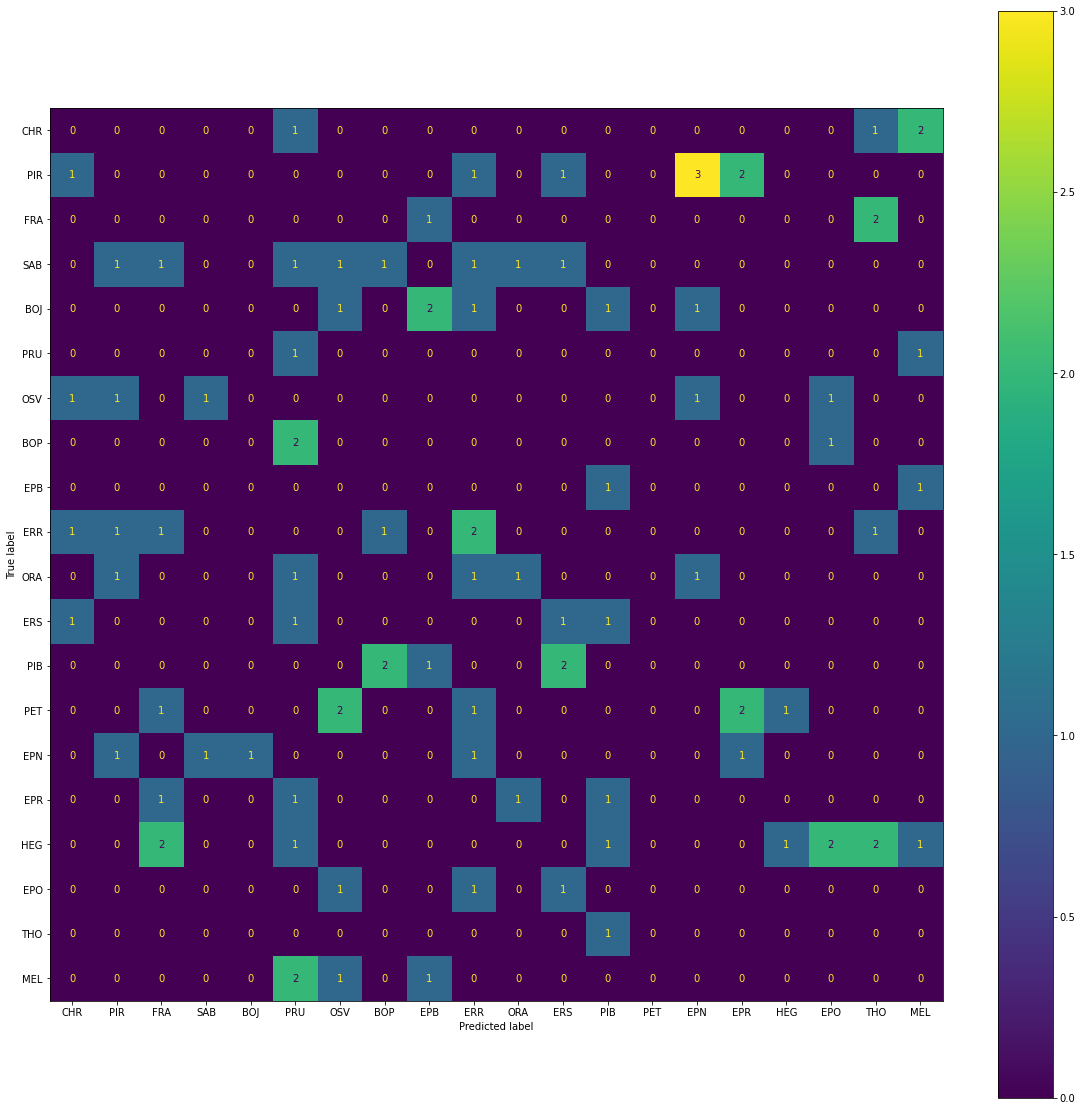

In [77]:
# Confusion matrix and saving

predictions = svc_sift.best_estimator_.predict(X_test_sift)
cm = confusion_matrix(y_test_sift, predictions, labels=svc_sift.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = classNames)
disp.plot()
plt.gcf().set_size_inches(20, 20)
plt.savefig("CM.png")
plt.show()